In [1]:
import numpy as np # linear algebra
import pandas as pd

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
df=pd.read_csv('/content/Crop_recommendation.csv')
df.head()

FileNotFoundError: [Errno 2] No such file or directory: '/content/Crop_recommendation.csv'

In [ ]:
df.describe()

In [ ]:
sns.heatmap(df.isnull(),cmap="coolwarm")
plt.show()


In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
# sns.distplot(df_setosa['sepal_length'],kde=True,color='green',bins=20,hist_kws={'alpha':0.3})
sns.distplot(df['temperature'],color="purple",bins=15,hist_kws={'alpha':0.2})
plt.subplot(1, 2, 2)
sns.distplot(df['ph'],color="green",bins=15,hist_kws={'alpha':0.2})

In [ ]:
sns.countplot(y='label',data=df, palette="plasma_r")

In [ ]:
sns.jointplot(x="K",y="N",data=df[(df['N']>40)&(df['K']>40)],hue="label")

In [ ]:
c=df.label.astype('category')
targets = dict(enumerate(c.cat.categories))
df['target']=c.cat.codes

y=df.target
X=df[['N','P','K','temperature','humidity','ph','rainfall']]

In [ ]:
sns.heatmap(X.corr())

In [ ]:
sns.boxplot(y='label',x='P',data=df[df['rainfall']>150])

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=1)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

# we must apply the scaling to the test set as well that we are computing for the training set
X_test_scaled = scaler.transform(X_test)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train_scaled, y_train)
knn.score(X_test_scaled, y_test)

<Axes: >

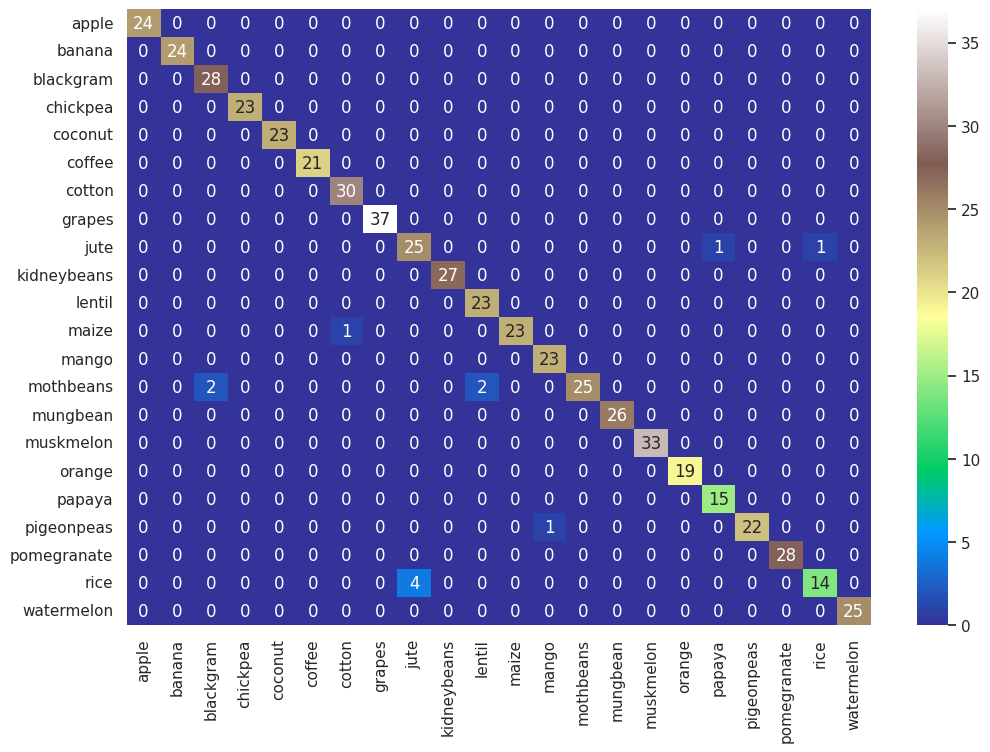

In [ ]:
from sklearn.metrics import confusion_matrix
mat=confusion_matrix(y_test,knn.predict(X_test_scaled))
df_cm = pd.DataFrame(mat, list(targets.values()), list(targets.values()))
sns.set(font_scale=1.0) # for label size
plt.figure(figsize = (12,8))
sns.heatmap(df_cm, annot=True, annot_kws={"size": 12},cmap="terrain")

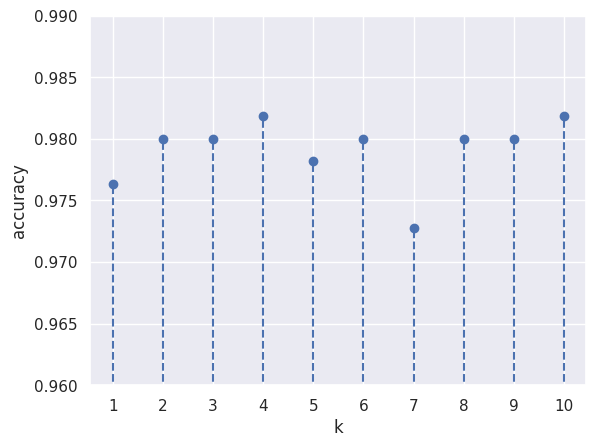

In [ ]:
k_range = range(1,11)
scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train_scaled, y_train)
    scores.append(knn.score(X_test_scaled, y_test))

plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.vlines(k_range,0, scores, linestyle="dashed")
plt.ylim(0.96,0.99)
plt.xticks([i for i in range(1,11)]);

In [ ]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)
clf.score(X_test,y_test)

0.9872727272727273

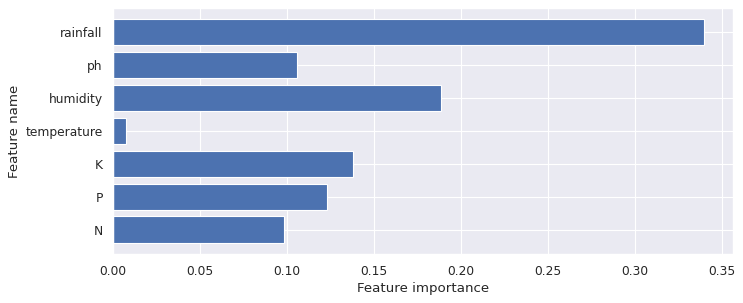

In [ ]:
plt.figure(figsize=(10,4), dpi=80)
c_features = len(X_train.columns)
plt.barh(range(c_features), clf.feature_importances_)
plt.xlabel("Feature importance")
plt.ylabel("Feature name")
plt.yticks(np.arange(c_features), X_train.columns)
plt.show()

In [ ]:
!pip install streamlit --quiet
!npm install localtunnel --quiet

In [ ]:
%%writefile app.py
import streamlit as st
import requests

# Function to get weather data
def get_weather_data(city):
    api_key = 'e7816266b7fb1b25d3126f54fbc2b91a'
  # Replace  OpenWeatherMap API key
    base_url = f'http://api.openweathermap.org/data/2.5/weather?q={city}&appid={api_key}&units=metric'
    response = requests.get(base_url)
    return response.json()

# Function to provide farming advice
def farming_advice(rain, temperature):
    if rain:
        return "Rain is expected. Ensure proper drainage for your fields to avoid waterlogging."
    else:
        if temperature > 30:
            return "High temperatures expected. Ensure adequate irrigation to keep crops hydrated."
        elif temperature < 10:
            return "Cold weather expected. Protect your crops from frost."
        else:
            return "Moderate weather expected. Continue regular farming practices."

st.title("Weather and Farming prediction")

# Input for city name
city = st.text_input("Enter your city:", "YourCity")

if city:
    weather_data = get_weather_data(city)

    if weather_data.get('cod') != 200:
        st.error("City not found.")
    else:
        temperature = weather_data['main']['temp']
        weather_description = weather_data['weather'][0]['description']
        rain = "rain" in weather_description.lower()

        st.write(f"Current Temperature: {temperature}°C")
        st.write(f"Weather Description: {weather_description.capitalize()}")

        advice = farming_advice(rain, temperature)
        st.write(f"Farming Advice: {advice}")

        # Extra: Estimate water needs based on temperature
        if not rain:
            water_needs = 5 if temperature > 30 else 3 if temperature > 20 else 2
            st.write(f"Estimated Water Needs: {water_needs} liters per square meter")

In [ ]:
!streamlit run app.py & npx localtunnel --port 8501